In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [2]:
from astropy.table import Table
import astropy.units as u
import astropy.constants as c

In [3]:
import sncosmo
from astropy.cosmology import FlatLambdaCDM
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
distmod = cosmo.distmod(z=0.0307)
distmod

<Quantity 35.64481825 mag>

In [5]:
z = 0.0307
beta1 = z
beta2 = ((1 + z)**2 - 1) / ((1 + z)**2 + 1)
beta1 * 299792.458, beta2 * 299792.458

(9203.6284606, 9062.417326687751)

In [6]:
DL = np.loadtxt('peculiar_vel.dat')[6]  #H0 = 70
#DL = 139.45 #H0 = 67.3
distmod = 5 * np.log10(DL * 1e6 / 10) * u.mag
distmod

<Quantity 35.63665805 mag>

In [17]:
leff_g = 4722.74  #AA
leff_r = 6339.61  #AA
rv = 3.1
ebv = 0.404
calALambda(leff_g, rv, ebv), calALambda(leff_r, rv, ebv)

(1.516916147247459, 1.0017554354796698)

In [8]:
lc = Table.read('ZTF20aayhacx_fnu.csv')
lc['mjd'] = lc['jd'] - 2400000.5
lc['mag'] = np.zeros_like(lc['mjd'])
lc['mag_unc'] = np.zeros_like(lc['mjd'])
lc = lc[np.where((lc['mjd'] > 58950) & (lc['mjd'] < 59100))]

lc_g = lc[lc['passband'] == 'ZTF_g']
lc_r = lc[lc['passband'] == 'ZTF_r']
lc_g['fnu_microJy'] = lc_g['fnu_microJy']
lc_g['fnu_microJy_uncmicroJy'] = lc_g['fnu_microJy_unc']
lc_r['fnu_microJy'] = lc_r['fnu_microJy']
lc_r['fnu_microJy_uncmicroJy'] = lc_r['fnu_microJy_unc']

argg1 = lc_g['fnu_microJy'] > lc_g['fnu_microJy_unc'] * 3
argg2 = lc_g['fnu_microJy'] <= lc_g['fnu_microJy_unc'] * 3
argr1 = lc_r['fnu_microJy'] > lc_r['fnu_microJy_unc'] * 3
argr2 = lc_r['fnu_microJy'] <= lc_r['fnu_microJy_unc'] * 3

In [9]:
arg = lc['fnu_microJy'] > lc['fnu_microJy_unc'] * 3
time = lc[arg]['mjd']
flux = lc[arg]['fnu_microJy']
fluxerr = lc[arg]['fnu_microJy_unc']
zp = np.ones_like(time) * 23.9  #AB magnitude for 1 micro Jansky
zpsys = ['ab' for i in range(len(time))]


def passband(b):
    if b == 'ZTF_g':
        return 'ztfg'
    if b == 'ZTF_r':
        return 'ztfr'
    if b == 'ZTF_i':
        return 'ztfi'


band = [passband(b) for b in lc[arg]['passband']]
data = Table([time, band, flux, fluxerr, zp, zpsys],
             names=['time', 'band', 'flux', 'fluxerr', 'zp', 'zpsys'])

In [13]:
g_bin = data_binning(
    np.array([lc_g['mjd'], lc_g['fnu_microJy'], lc_g['fnu_microJy_unc']]).T)
mjd, fl, fl_unc = g_bin[:, 0], g_bin[:, 1], g_bin[:, 2]
arg1 = fl > fl_unc * 3
arg2 = fl <= fl_unc * 3
mag = np.zeros_like(fl)
mag_unc = np.zeros_like(fl)
mag[arg1] = -2.5 * np.log10(fl[arg1]) + 23.9 - distmod.value - calALambda(
    leff_g, rv, ebv)
mag[arg2] = -2.5 * np.log10(fl_unc[arg2] * 5) + 23.9 - distmod.value - calALambda(
    leff_g, rv, ebv)
mag_unc[arg1] = -2.5 * np.log10((fl - fl_unc)[arg1] / (fl + fl_unc)[arg1]) / 2
mag_unc[arg2] = -999

In [14]:
lc_g['mag'][argg1] = -2.5 * np.log10(
    lc_g[argg1]['fnu_microJy']) + 23.9 - distmod.value - calALambda(
        leff_g, rv, ebv)
lc_g['mag'][argg2] = -2.5 * np.log10(
    lc_g[argg2]['fnu_microJy_unc'] * 5) + 23.9 - distmod.value - calALambda(
        leff_g, rv, ebv)
lc_g['mag_unc'][argg1] = -2.5 * np.log10(
    (lc_g[argg1]['fnu_microJy'] - lc_g[argg1]['fnu_microJy_unc']) /
    (lc_g[argg1]['fnu_microJy'] + lc_g[argg1]['fnu_microJy_unc'])) / 2
lc_g['mag_unc'][argg2] = -999

lc_r['mag'][argr1] = -2.5 * np.log10(
    lc_r[argr1]['fnu_microJy']) + 23.9 - distmod.value - calALambda(
        leff_r, rv, ebv)
lc_r['mag'][argr2] = -2.5 * np.log10(
    lc_r[argr2]['fnu_microJy_unc'] * 5) + 23.9 - distmod.value - calALambda(
        leff_r, rv, ebv)
lc_r['mag_unc'][argr1] = -2.5 * np.log10(
    (lc_r[argr1]['fnu_microJy'] - lc_r[argr1]['fnu_microJy_unc']) /
    (lc_r[argr1]['fnu_microJy'] + lc_r[argr1]['fnu_microJy_unc'])) / 2
lc_r['mag_unc'][argr2] = -999

Text(0, 0.5, '$\\mathrm{M}$')

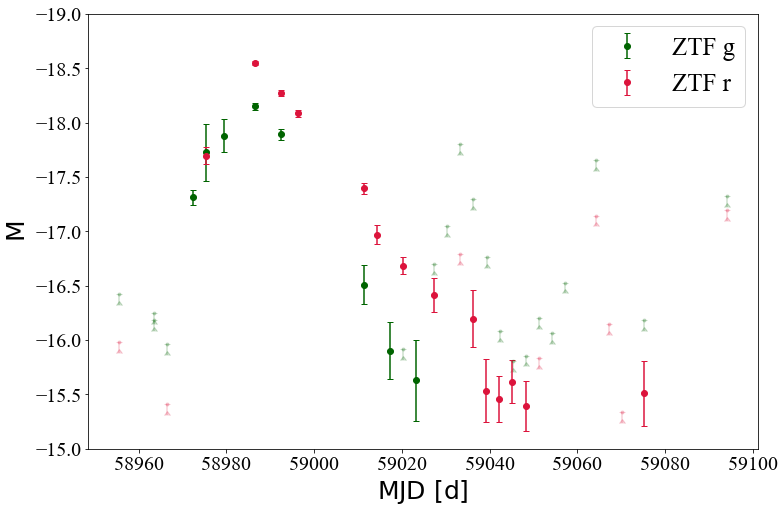

In [15]:
plt.figure(figsize=(12, 8))
plt.errorbar(lc_g[argg1]['mjd'],
             lc_g[argg1]['mag'],
             yerr=lc_g[argg1]['mag_unc'],
             fmt='o',
             capsize=3,
             color='darkgreen',
             label='ZTF g')
plt.errorbar(lc_g[argg2]['mjd'],
             lc_g[argg2]['mag'] + .1,
             yerr=.1,
             lolims=True,
             fmt='.',
             capsize=3,
             color='darkgreen',
             alpha=0.2)
plt.errorbar(lc_r[argr1]['mjd'],
             lc_r[argr1]['mag'],
             yerr=lc_r[argr1]['mag_unc'],
             fmt='o',
             capsize=3,
             color='crimson',
             label='ZTF r')
plt.errorbar(lc_r[argr2]['mjd'],
             lc_r[argr2]['mag'] + .1,
             yerr=.1,
             lolims=True,
             fmt='.',
             capsize=3,
             color='crimson',
             alpha=0.2)
plt.ylim(-19, -15)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel(r'$\mathrm{MJD\ [d]}$')
plt.ylabel(r'$\mathrm{M}$')

In [18]:
# mjd, mag, mag_unc
# upper limits: mag = 5sigma, mag_unc = -999
X = np.array([lc_g['mjd'], lc_g['mag'], lc_g['mag_unc']]).T
np.savetxt('SN2020jgb_ZTF_g.dat', X, fmt='%.5f')
Y = np.array([lc_r['mjd'], lc_r['mag'], lc_r['mag_unc']]).T
np.savetxt('SN2020jgb_ZTF_r.dat', Y, fmt='%.5f')

In [21]:
# From Bulla, Miller+2020

gr_population = pd.read_csv('color/gr_adam.txt', 
                            delim_whitespace=True, comment='#',
                            names=['SN', 't', 'e_t_min', 'e_t_max', 
                                   'gr', 'e_gr_min', 'e_gr_max',
                                   'type', 'marker'])

normal_ia = np.where((gr_population.type == 'normal*') |
                     (gr_population.type == 'normal') | 
                     (gr_population.type == '91T-like') |
                     (gr_population.type == '99aa-like') | 
                     (gr_population.type == '99aa-like*')
                    )

print('There are {} normal SNe in this sample'.format(len(gr_population.iloc[normal_ia].SN.unique())))

gr_population.head(5)

There are 62 normal SNe in this sample


,SN,t,e_t_min,e_t_max,gr,e_gr_min,e_gr_max,type,marker
0,ZTF18aapqwyv,2.111188,0.685375,0.529521,0.242970,0.368273,0.384782,normal*,o
1,ZTF18aapqwyv,3.032216,0.685375,0.529521,0.945111,0.297778,0.358075,normal*,o
2,ZTF18aapqwyv,3.974450,0.685375,0.529521,0.270548,0.168496,0.161108,normal*,o
3,ZTF18aapqwyv,4.973797,0.685375,0.529521,0.125119,0.193820,0.177315,normal*,o
4,ZTF18aapqwyv,16.227165,0.685375,0.529521,-0.131547,0.033107,0.033027,normal*,o


In [22]:
def mag1_mag2(X, Y, bin_size=1, intp=False):
    t1, t2 = X[:, 0], Y[:, 0]
    mag1, mag2 = X[:, 1], Y[:, 1]
    unc1, unc2 = X[:, 2], Y[:, 2]
    if intp:
        t1, mag1, unc1 = interp(t1, mag1, unc1)
        t2, mag2, unc2 = interp(t2, mag2, unc2)
    #print(len(t1), len(mag1))
    i, j = 0, 0
    T = []
    Mag, Unc = [], []
    while i < len(t1):
        while t2[j] < t1[i] + bin_size:
            if (np.abs(t2[j] - t1[i]) < bin_size):
                t = (t1[i] / unc1[i]**2 +
                     t2[j] / unc2[j]**2) / (1 / unc1[i]**2 + 1 / unc2[j]**2)
                mag = (mag1[i] - mag2[j])
                unc = (unc1[i]**2 + unc2[j]**2)**.5
                T = np.append(T, t)
                Mag = np.append(Mag, mag)
                Unc = np.append(Unc, unc)
                break
            j += 1
        i += 1
    arg = np.argwhere(Unc < 999).flatten()
    return T[arg], Mag[arg], Unc[arg]

In [23]:
spec_gr = np.loadtxt('../spectroscopy/spec_gr.txt')

In [28]:
tfo = min(X[np.argwhere(X[:, -1] > 0)[0], 0], Y[np.argwhere(Y[:, -1] > 0)[0],
                                                0])[0]
tno = max(X[np.argwhere(X[:, -1] > 0)[0] - 1, 0],
          Y[np.argwhere(Y[:, -1] > 0)[0] - 1, 0])[0]
tfl = tno#(tfo + tno) / 2
tfl_unc = (tfo - tno) / 2
print(tfl, tfl_unc)

58966.47746529989 2.9927488500252366


In [29]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(
    1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))

tG = np.atleast_2d(X[X[:, 2] > 0, 0]).T
gmag = X[X[:, 2] > 0, 1]
gmag_unc = X[X[:, 2] > 0, 2]

tR = np.atleast_2d(Y[Y[:, 2] > 0, 0]).T
rmag = Y[Y[:, 2] > 0, 1]
rmag_unc = Y[Y[:, 2] > 0, 2]

gpG = GPR(kernel=kernel, alpha=gmag_unc**2, n_restarts_optimizer=10)
gpG.fit(tG, gmag)
gpR = GPR(kernel=kernel, alpha=rmag_unc**2, n_restarts_optimizer=20)
gpR.fit(tR, rmag)

t = np.linspace(tno, 59030, 100)
tgp = np.atleast_2d(t).T
gmag_pred, dgmag_pred = gpG.predict(tgp, return_std=1)
rmag_pred, drmag_pred = gpR.predict(tgp, return_std=1)

gr_gp = (gmag_pred - rmag_pred).ravel()
gr_gp_unc = (dgmag_pred**2 + drmag_pred**2).ravel()**.5

(0.9, 300)

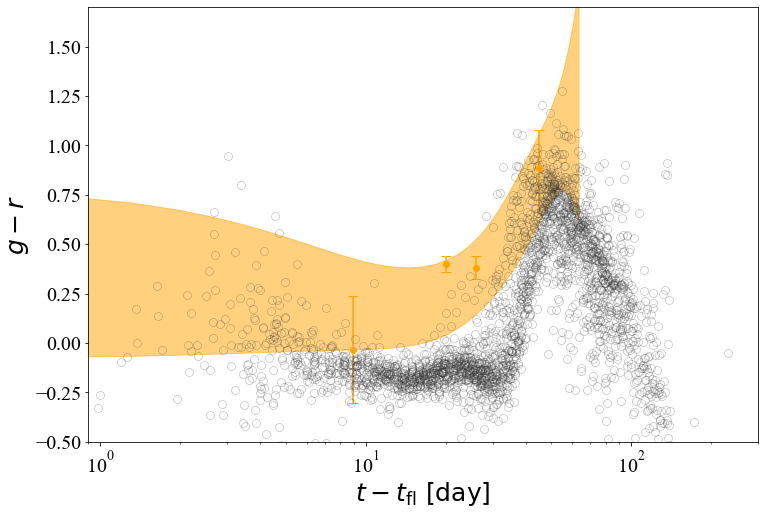

In [30]:
plt.figure(figsize=(12, 8))
T, Mag, Unc = mag1_mag2(X, Y, bin_size=1)
'''plt.errorbar(spec_gr[:, 0],
             spec_gr[:, 1],
             yerr=spec_gr[:, 2],
             fmt='o',
             capsize=5,
             color='k',
             alpha=0.5)'''
plt.errorbar(T - tfl, Mag, yerr=Unc, fmt='o', capsize=5, color='orange')
plt.fill_between(tgp.ravel() - tfl,
                 gr_gp - gr_gp_unc,
                 gr_gp + gr_gp_unc,
                 color='orange',
                 alpha=0.5)
plt.plot(gr_population.iloc[normal_ia].t.values,
         gr_population.iloc[normal_ia].gr.values,
         'o',
         color='None',
         mec='0.2',
         mew=0.4,
         ms=8,
         alpha=0.5)
plt.ylabel('$g-r$')
plt.xlabel('$t-t_\mathrm{fl}\ [\mathrm{day}]$')
plt.xscale('log')
plt.ylim(-0.5, 1.7)
plt.xlim(0.9, 300)
#plt.xlabel('$t-t_\mathrm{peak}\ [\mathrm{day}]$')

# SALT2 Fit

In [194]:
# create a model
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2',
                      effects=[dust, dust],
                      effect_names=['host', 'mw'],
                      effect_frames=['rest', 'obs'])

# set the model's redshift
model.set(z=0.0307)

# set the model's galactic extinction
model.set(mwebv=0.404)
# run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model, ['t0', 'x0', 'x1', 'c'])  # parameters of model to vary

In [195]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 114
Number of degrees of freedom in fit: 18
chi^2 value at minimum: 233.59154468046685
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 3.07000000e-02  5.89836299e+04  1.55415151e-03 -1.03537629e+00
  4.22991358e-01  0.00000000e+00  3.10000000e+00  4.04000000e-01
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


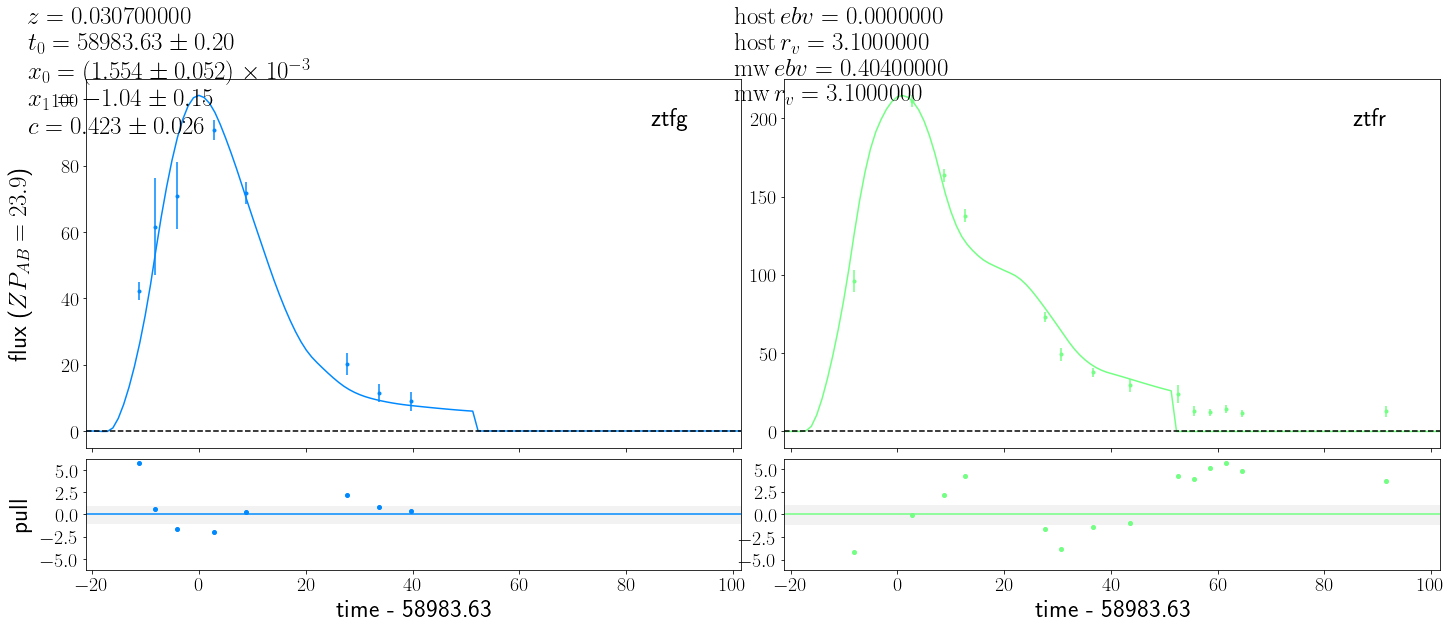

In [196]:
sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, zp=23.9, xfigsize=20);